Classification of Toxic Tweets

In [ ]:
# modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# result
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')          # graph settings
plt.rcParams['figure.figsize'] = (12,5)    # graph settings

# data preprocessing
from sklearn.model_selection import train_test_split

# data wrangling
import numpy as np
import pandas as pd
# corpus
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# string manipulation
import re
import spacy
import collections

<ipython-input-1-00de20ce5c61>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')          # graph settings


In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Import Data

In [ ]:
df = pd.read_csv("/content/FinalBalancedDataset.csv")
df = df.drop(columns = ['Unnamed: 0'])
df.head()

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


Data Visualization (ALL)

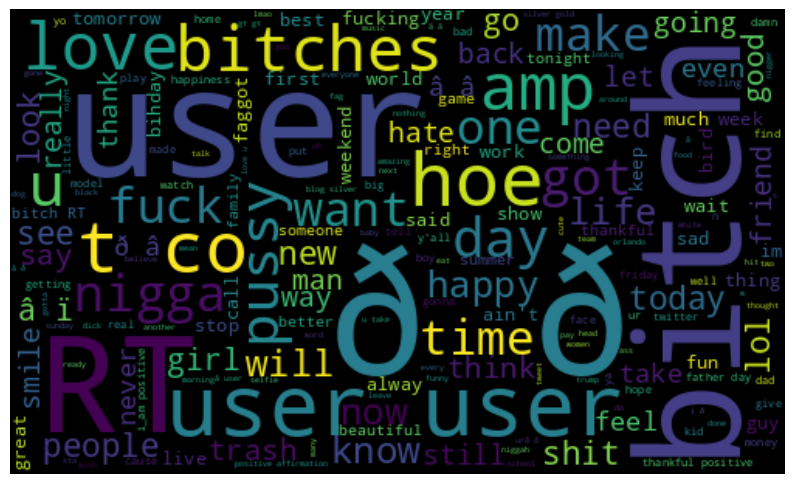

In [ ]:
import wordcloud
from wordcloud import WordCloud
allWords = ' '.join([twts for twts in df['tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Visualize Toxic Tweets

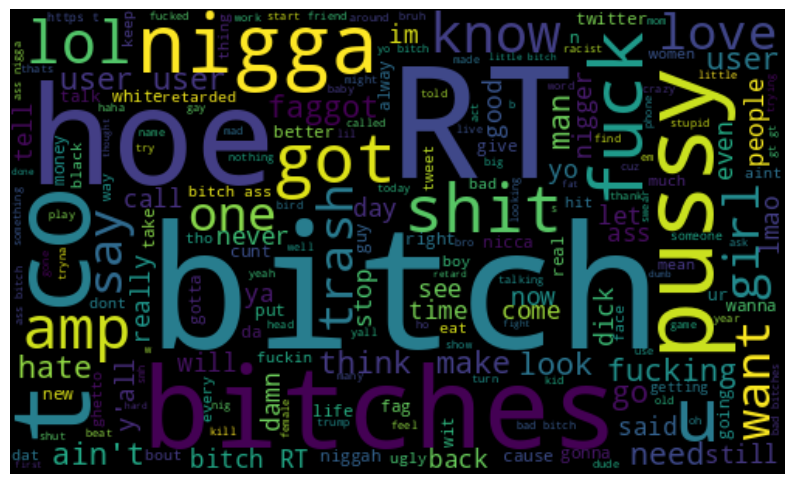

In [ ]:
allWords = ' '.join([twts for twts in df[df['Toxicity'] == 1]['tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Visualize Non-Toxic Tweets

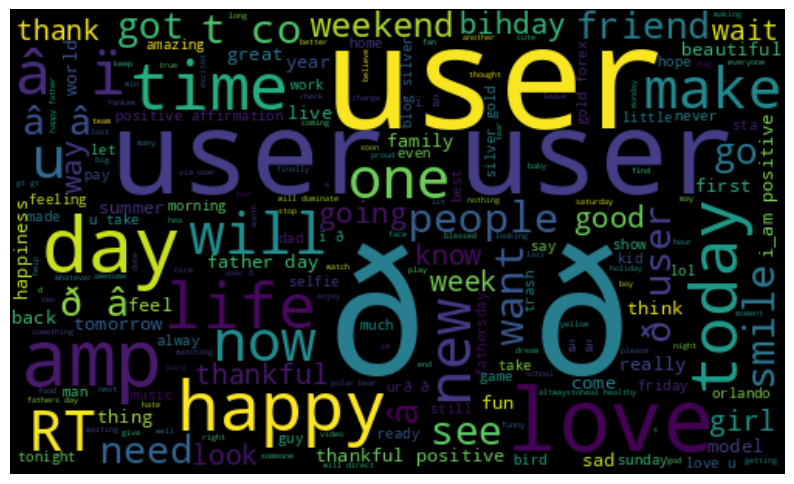

In [ ]:
allWords = ' '.join([twts for twts in df[df['Toxicity'] == 0]['tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Cleaning Data

In [ ]:
X = df['tweet'].copy()
y = df['Toxicity'].copy()

In [ ]:
def data_cleaner(tweet):
    tweet = tweet.lower()
    tweet = tweet.replace(":("," sedih")
    tweet = tweet.replace(":)"," senang")
    tweet = tweet.replace(":3"," lucu")
    tweet = tweet.replace(":d"," senang")
    tweet = tweet.replace(":-)"," senang")
    tweet = tweet.replace("=)"," senang")
    tweet = re.sub(r'http\S+', ' ', tweet)   # remove urls
    tweet = re.sub(r'<.*?>',' ', tweet)      # remove html tags
    tweet = re.sub(r'\d+',' ', tweet)        # remove digits
    tweet = re.sub(r'#\w+',' ', tweet)       # remove hashtags
    tweet = re.sub(r'@\w+',' ', tweet)       # remove mentions
    tweet = re.sub(r'[^\w\s]',' ', tweet)    # remove punctuation
    tweet = re.sub('[^A-Za-z0-9 ]+', '', tweet) # remove characters that are not a letters or numbers
    tweet = " ".join([word for word in tweet.split() if not word in stop_words])   # remove stop words
    tweet = stemmer.stem(tweet)
    tweet = tweet.strip()
    return tweet

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")

#X.apply(data_cleaner)
X_cleaned = X.apply(data_cleaner)
X_cleaned

0         father dysfunctional selfish drags kids dysfunct
1        thanks credit use cause offer wheelchair vans pdx
2                                           bihday majesti
3                                    love u take u time ur
4                                       factsguide societi
                               ...                        
56740    muthaf lie pearls right tl trash mine bible sc...
56741      gone broke wrong heart baby drove redneck crazi
56742    young buck wanna eat dat nigguh like aint fuck...
56743                      youu got wild bitches tellin li
56744    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 56745, dtype: object

Tokenizing

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X = tokenizer.texts_to_sequences(X_cleaned)
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[0]))
print("\nAfter tokenizing :\n{}".format(X[0]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[0]))

Vocabulary size: 32482

Example:

Sentence:
father dysfunctional selfish drags kids dysfunct

After tokenizing :
[84, 15821, 2171, 7477, 266, 11263]

After padding :
[   84 15821  2171  7477   266 11263     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [ ]:
Check Distribution of Class

<Axes: xlabel='Toxicity', ylabel='count'>

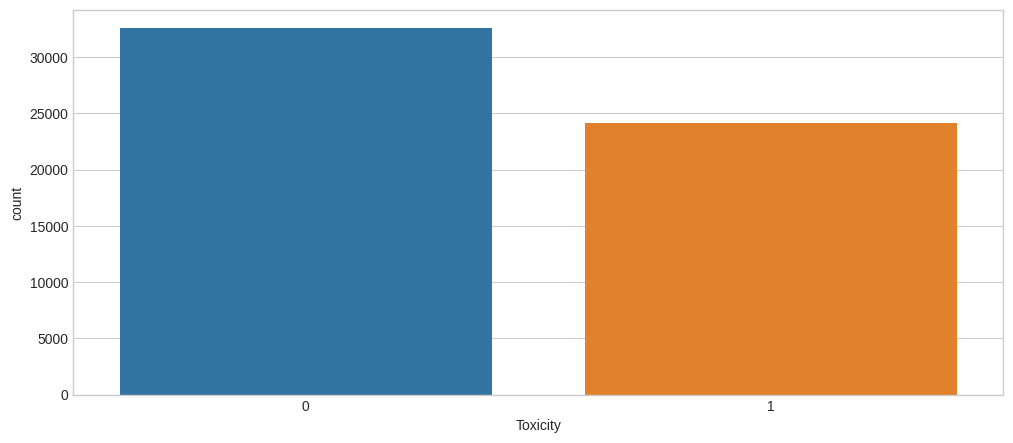

In [ ]:
sns.countplot(x = "Toxicity",data = df)

Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

Model Building and Training

In [ ]:
tf.keras.backend.clear_session()

# hyperparameters
EPOCHS = 2
BATCH_SIZE = 64
embedding_dim = 64
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.GRU(units, return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(512, activation="sigmoid"),
    L.Dropout(0.4),
    L.Dense(2, activation = "softmax")
])

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 64)            2078848   
                                                                 
 bidirectional (Bidirectiona  (None, 37, 512)          494592    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
history = model.fit(X_train, y_train, epochs=2, validation_data = (X_test,y_test), batch_size=BATCH_SIZE)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


665/665 [==============================] - 242s 357ms/step - loss: 0.2435 - accuracy: 0.9019 - val_loss: 0.1778 - val_accuracy: 0.9342
Epoch 2/2
665/665 [==============================] - 235s 354ms/step - loss: 0.1242 - accuracy: 0.9553 - val_loss: 0.2053 - val_accuracy: 0.9242


Predict Data Test

In [ ]:
predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))


444/444 [==============================] - 26s 55ms/step
Test loss: 0.20532456040382385
Test Accuracy: 0.9242264032363892


Confusion Matrix

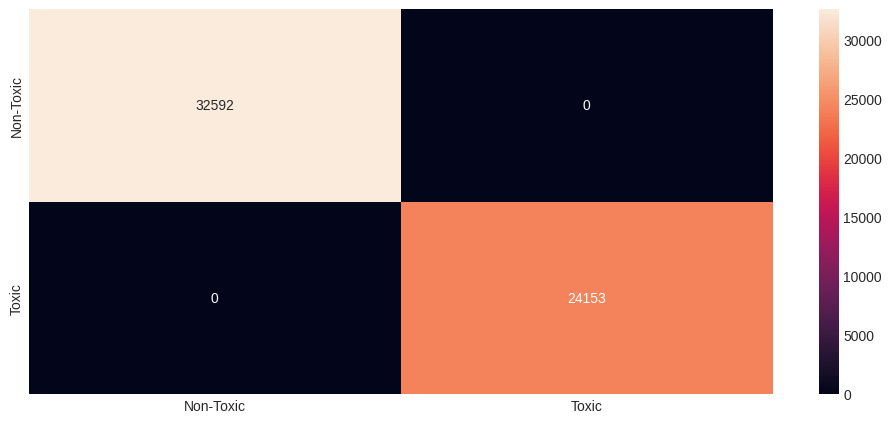

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have loaded your data into a pandas DataFrame called `data`
y_test = df['Toxicity']
predict_x = df['Toxicity']  # Assuming you are predicting the labels and storing them in `predict_x`

# Compute confusion matrix
conf = confusion_matrix(y_test, predict_x)

# Define labels for the confusion matrix
labels = ['Non-Toxic', 'Toxic']

# Create a DataFrame from the confusion matrix
cm = pd.DataFrame(conf, index=labels, columns=labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

Classification Report

In [ ]:
print(classification_report(y_test, predict_x, target_names=labels))

              precision    recall  f1-score   support

   Non-Toxic       1.00      1.00      1.00     32592
       Toxic       1.00      1.00      1.00     24153

    accuracy                           1.00     56745
   macro avg       1.00      1.00      1.00     56745
weighted avg       1.00      1.00      1.00     56745

